0.2326564545693799
Static_ZZ(MHz)= 0.2326564545693799 bare_F_01 =  0.5279804326118707 bare_F_12 = 3.6200218756067684 bare_T_01= 5.239105326612123 bare_F_03= 6.7345733516408925
Static_ZZ(MHz)=  0.23265645456760353
dressed_F_01(GHz)=  0.5282238355184874
dressed_F_12(GHz)=  3.621675075635656
dressed_F_03(GHz)=  6.737893349660463
dressed_T_01(GHz)=  5.241662988665894


Text(0.5, 1.0, 'Control (Fluxonium) in state |0>')

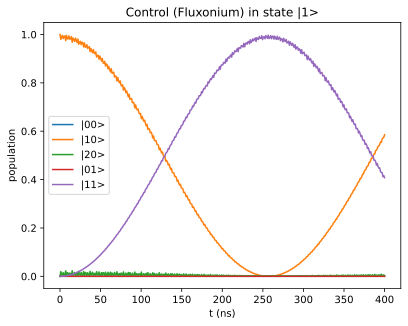

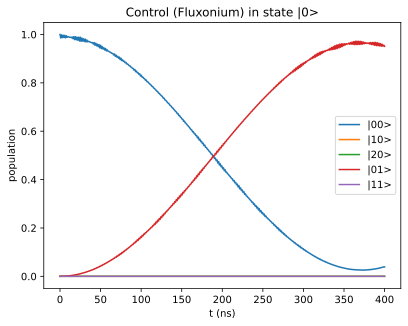

In [4]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.0617,
    EJ = 4.1933,
    EL=.9336,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Transmon(
     EJ=19.98,
     EC=0.1845,
     ng=0,
     ncut=110,
     truncated_dim=20)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.0222,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 15

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz









n_diff = abs(np.round(n_a[0,2],5)-np.round(n_a[1,4],5))
n_A_01 = np.round(qbta.n_operator(energy_esys=True)[0][1],5)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
detuning  = abs(bare_states_a[1]-bare_states_b[1])

t_fsl = abs(n_A_01*2*np.pi/n_diff/detuning)


print(Static_ZZ)
print('Static_ZZ(MHz)=',Static_ZZ, 'bare_F_01 = ',bare_states_a[1],'bare_F_12 =',bare_states_a[2]-bare_states_a[1],'bare_T_01=',bare_states_b[1],'bare_F_03=',bare_states_a[3])




e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_11-e_10
A=.22*2
def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]

eta = -n_a_00_01/n_b_00_01


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)

tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * n_a, cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:5], result.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")

0.2326564545693799
Static_ZZ(MHz)= 0.2326564545693799 bare_F_01 =  0.5279804326118707 bare_F_12 = 3.6200218756067684 bare_T_01= 5.239105326612123 bare_F_03= 6.7345733516408925
Static_ZZ(MHz)=  0.23265645456760353
dressed_F_01(GHz)=  0.5282238355184874
dressed_F_12(GHz)=  3.621675075635656
dressed_F_03(GHz)=  6.737893349660463
dressed_T_01(GHz)=  5.241662988665894


Text(0.5, 1.0, 'Control (Fluxonium) in state |0>')

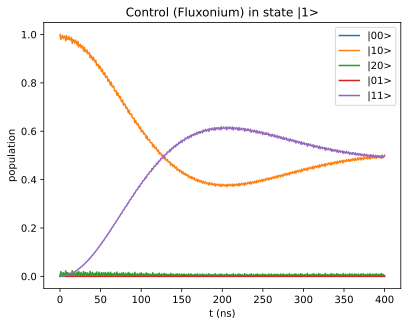

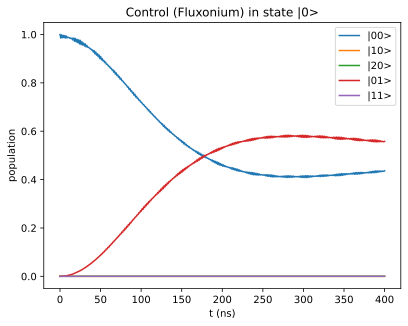

In [18]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.0617,
    EJ = 4.1933,
    EL=.9336,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Transmon(
     EJ=19.98,
     EC=0.1845,
     ng=0,
     ncut=110,
     truncated_dim=20)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.0222,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 15

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz









n_diff = abs(np.round(n_a[0,2],5)-np.round(n_a[1,4],5))
n_A_01 = np.round(qbta.n_operator(energy_esys=True)[0][1],5)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
detuning  = abs(bare_states_a[1]-bare_states_b[1])

t_fsl = abs(n_A_01*2*np.pi/n_diff/detuning)


print(Static_ZZ)
print('Static_ZZ(MHz)=',Static_ZZ, 'bare_F_01 = ',bare_states_a[1],'bare_F_12 =',bare_states_a[2]-bare_states_a[1],'bare_T_01=',bare_states_b[1],'bare_F_03=',bare_states_a[3])




e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_11-e_10
A=.22*2
def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]

eta = -n_a_00_01/n_b_00_01 *1j


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)

tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a+eta*n_b), cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:5], result.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")

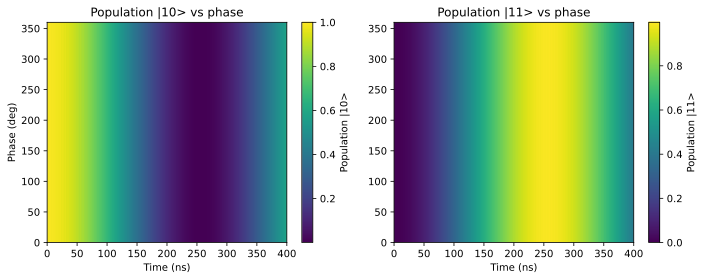

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set eta magnitude
eta_mag = np.abs(-n_a_00_01/n_b_00_01)*0
phases = np.linspace(-np.pi, np.pi, 20)
pop_10 = np.zeros((len(phases), len(tlist)))
pop_11 = np.zeros((len(phases), len(tlist)))

idx_10 = hilbertspace.dressed_index((1,0))
idx_11 = hilbertspace.dressed_index((1,1))

for i, phi in enumerate(phases):
    eta_phase = eta_mag * np.exp(1j * phi)
    H_qbt_drive = [
        diag_dressed_hamiltonian_trunc,
        [2 * np.pi * (n_a + eta_phase * n_b), cosine_drive],
    ]
    result = qt.sesolve(
        H_qbt_drive,
        qt.basis(total_truncation, idx_10),  # Control in |1>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    pop_10[i, :] = result.expect[idxs.index(idx_10)]
    pop_11[i, :] = result.expect[idxs.index(idx_11)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pop_10, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |10>')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (deg)')
plt.title('Population |10> vs phase')

plt.subplot(1,2,2)
plt.imshow(pop_11, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |11>')
plt.xlabel('Time (ns)')
plt.title('Population |11> vs phase')

plt.tight_layout()
plt.show()

In [10]:
hilbertspace.dressed_index((1,1))

np.int64(4)

In [12]:
n_a_10_11 = n_a[hilbertspace.dressed_index((1,0)),hilbertspace.dressed_index((1,1))]
n_b_10_11 = n_b[hilbertspace.dressed_index((1,0)),hilbertspace.dressed_index((1,1))]

H_cr_sd = n_a_10_11 + eta*n_b_10_11
print('H_cr_sd = ',H_cr_sd)
print('eta = ',eta)
print('n_a_10_11 = ',n_a_10_11)

H_cr_sd =  (-0.007337658510485354+0.002766689203285781j)
eta =  (0.0025422641975268987+2.3024386668742536e-16j)
n_a_10_11 =  (-0.004169138815069184+0.0015719880299921497j)


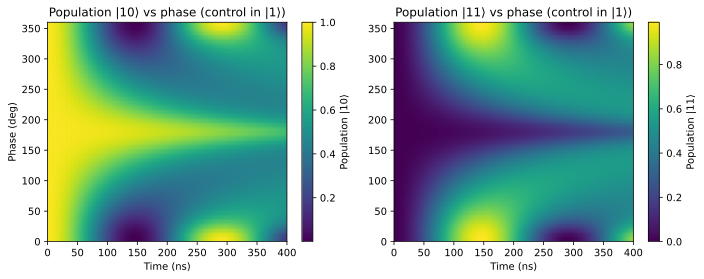

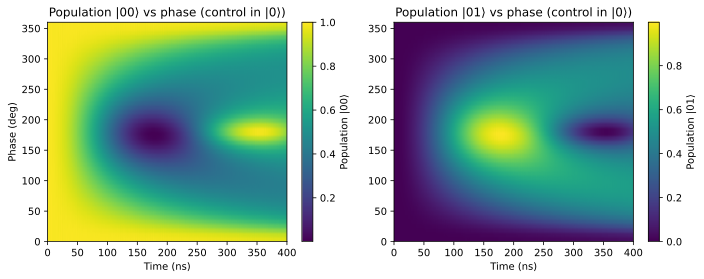

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Set eta as fixed magnitude and scan phase
eta_base = -n_a_00_01 / n_b_00_01 
eta_mag = np.abs(eta_base)
phases = np.linspace(0, 2*np.pi, 50)  # 0 to 2pi for full phase scan

pop_10 = np.zeros((len(phases), len(tlist)))
pop_11 = np.zeros((len(phases), len(tlist)))
pop_00 = np.zeros((len(phases), len(tlist)))
pop_01 = np.zeros((len(phases), len(tlist)))

idx_00 = hilbertspace.dressed_index((0,0))
idx_01 = hilbertspace.dressed_index((0,1))
idx_10 = hilbertspace.dressed_index((1,0))
idx_11 = hilbertspace.dressed_index((1,1))

for i, phi in enumerate(phases):
    eta_phase = eta_mag * np.exp(1j * phi)
    # Control in |1>
    H_qbt_drive = [
        diag_dressed_hamiltonian_trunc,
        [2 * np.pi * (n_a + eta_phase * n_b), cosine_drive],
    ]
    result = qt.sesolve(
        H_qbt_drive,
        qt.basis(total_truncation, idx_10),  # Control in |1>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    pop_10[i, :] = result.expect[idxs.index(idx_10)]
    pop_11[i, :] = result.expect[idxs.index(idx_11)]

    # Control in |0>
    result2 = qt.sesolve(
        H_qbt_drive,
        qt.basis(total_truncation, idx_00),  # Control in |0>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    pop_00[i, :] = result2.expect[idxs.index(idx_00)]
    pop_01[i, :] = result2.expect[idxs.index(idx_01)]

# Plot for control in |1>
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pop_10, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |10⟩')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (deg)')
plt.title('Population |10⟩ vs phase (control in |1⟩)')

plt.subplot(1,2,2)
plt.imshow(pop_11, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |11⟩')
plt.xlabel('Time (ns)')
plt.title('Population |11⟩ vs phase (control in |1⟩)')

plt.tight_layout()
plt.show()

# Plot for control in |0>
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pop_00, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |00⟩')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (deg)')
plt.title('Population |00⟩ vs phase (control in |0⟩)')

plt.subplot(1,2,2)
plt.imshow(pop_01, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |01⟩')
plt.xlabel('Time (ns)')
plt.title('Population |01⟩ vs phase (control in |0⟩)')

plt.tight_layout()
plt.show()